In [2]:
from jax import grad, vmap, jit
from jax import make_jaxpr
import jax.numpy as jnp
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

# Differentiation
The derivative of a function in jax is obtained by applying the `grad` function to the original function.
The result of this is a new function that can be evaluated for a choice of x.

∂f∂x(0.0) is 1.0


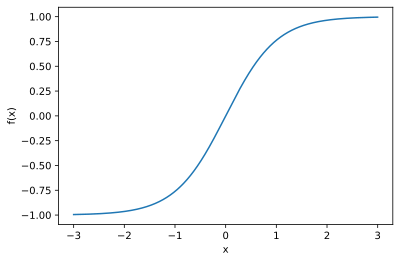

In [3]:
def f(x):
    return jnp.tanh(x)

x = jnp.arange(-3.0, 3.0, 0.001)

fig, ax = plt.subplots()
ax.plot(x, f(x), label="f(x)")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
print(f"∂f∂x(0.0) is {grad(f)(0.0)}")

In [4]:
print(make_jaxpr(f)(0.0))
print(make_jaxpr(grad(f))(0.0))

{ lambda ; a:f32[]. let b:f32[] = tanh a in (b,) }
{ lambda ; a:f32[]. let
    b:f32[] = tanh a
    c:f32[] = sub 1.0 b
    d:f32[] = mul 1.0 c
    e:f32[] = mul d b
    f:f32[] = add_any d e
  in (f,) }


# Automatic vectorization 
Code written in Numpy often relies on the reshaping arrays to leverage broadcasting rules in order for the code to run on several stacked inputs at once.
The benefit is that the code typically runs much faster than iterating over the leading dimension using a for loop in Python.
The drawback of this is that the implementation of a batched function is much harder to understand than the elementwise version.



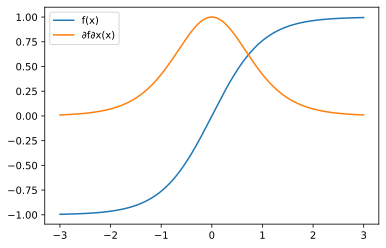

In [55]:
plt.plot(x,f(x),label='f(x)')
plt.plot(x,vmap(grad(f))(x),label='∂f∂x(x)')
plt.legend()

Inspecting the `jaxpr` we see that the vmap has created a specialized version of the function that takes as an argument.

In [56]:
print(make_jaxpr(vmap(grad(f)))(x))

{ lambda ; a:f32[6000]. let
    b:f32[6000] = tanh a
    c:f32[6000] = sub 1.0 b
    d:f32[6000] = mul 1.0 c
    e:f32[6000] = mul d b
    f:f32[6000] = add_any d e
  in (f,) }


# Just-in-time compilation

Under the hood the `grad` function creates a new function. 
The first time this function is evaluated with an input, a placeholder value that records all the mathematical operations carried out in the function body.
The operations are recorded in `jaxpr` format, that can be viewed using the `make_jaxpr` function.

315 µs ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
13.1 µs ± 888 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


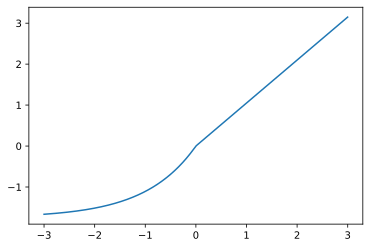

In [57]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(
    x > 0, x, alpha * jnp.exp(x) - alpha)

%timeit selu(x).block_until_ready()

selu_jit = jit(selu)
selu_jit(x).block_until_ready() # warmup
%timeit selu_jit(x).block_until_ready()

plt.plot(x,selu(x))

In [ ]:
print(string(jax))

# Regression example

Consider the following regression 1-D regression problem
$
y(x) = a x + b + \epsilon
$
where $\epsilon \sim \mathcal{N}(0,1)$

Using Jax we will estimate the parameters $a$ and $b$ from the data.

Text(0, 0.5, 'f(x)')

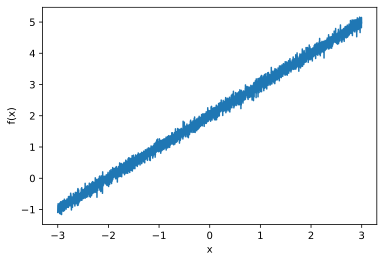

In [58]:
from jax import random
key = random.PRNGKey(1)

a = 1.0
b = 2.0
e = random.normal(key,x.shape)*1e-1
y = a*x + b + e

fig, ax = plt.subplots()
ax.plot(x,y)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")

We want to find a model $\hat{y}(x) = \hat{a} x + \hat{b}$ which minimizes $|\hat{y}(x)-y(x)|_2$ over the set of inputs.

100%|██████████| 1000/1000 [00:00<00:00, 4612.11it/s]


a: 0.9992426037788391, b: 2.0001001358032227


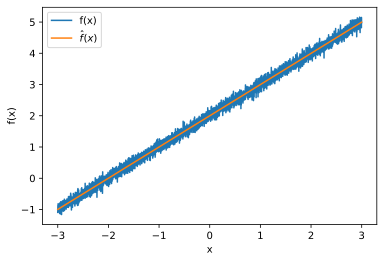

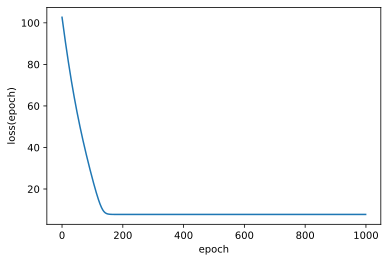

In [63]:
from jax import value_and_grad
from tqdm import tqdm

a_estimate = 0.5
b_estimate = 1.0
learning_rate = 0.0001
n_epochs = 1000
losses = []

def loss(a,b):
    y_predicted = a*x + b
    return jnp.linalg.norm(y-y_predicted)

def update(a,b):
    value, (dlda, dldb) = value_and_grad(loss, argnums=(0,1))(a,b)
    a -= learning_rate * dlda
    b -= learning_rate * dldb
    return value, a,b

update_jit = jit(update)

for i in tqdm(range(n_epochs)):
    value, a_estimate, b_estimate = update_jit(a_estimate,b_estimate)
    losses.append(value)
y_estimate = a_estimate * x + b_estimate

fig, ax = plt.subplots()
ax.plot(x,y,label='f(x)')
ax.plot(x,y_estimate,label='$\hatf(x)$')
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("f(x)")

fig, ax = plt.subplots()
ax.plot(jnp.array(losses))
ax.set_xlabel("epoch")
ax.set_ylabel("loss(epoch)")
print(f"a: {a_estimate}, b: {b_estimate}")